## PHYS-243 Spring 2019 - Brandon Evans - Midterm
#### Dr. Mobasher, TA Abtin Shahidi
#### 14-May-2019, Revised 19-May-2019

In [316]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from scipy.stats import zscore

%matplotlib inline

### Wine Dataset
#### Assumptions/Expectations:
*  Check the dataset README file
*  Use Pandas because it has good CSV reader and I'm familiar
*  No categorical input variables to label encode
*  Treat output/response variable as categorical, not continuous

### Step 1 - Get the dataset

In [7]:
#Fetch/Extract data
!curl -O https://raw.githubusercontent.com/abtinshahidi/Foundation_applied_machine_learning/master/midterm/data_sets/4_wine_quality/winequality-red.csv
    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84199  100 84199    0     0   126k      0 --:--:-- --:--:-- --:--:--  126k





##### Attribute information:
For more information, read [Cortez et al., 2009].

`   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)`


In [10]:
#Preview some data
CSV_FILE = 'winequality-red.csv'
df = pd.read_csv(CSV_FILE, delimiter=';')

In [11]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Step 2 - Data Inspect/Clean - How does data look?  Any crazy ranges or deviations that might suggest data errors.  Any missing data we need to figure out a strategy to fill or omit?

In [12]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [26]:
#Any null values?
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Step 3 - Explore, get to know the data...

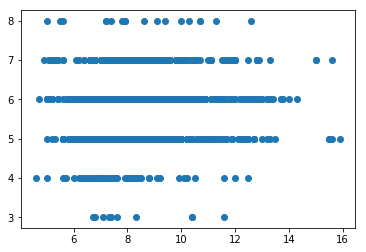

In [24]:
plt.scatter(df['fixed acidity'],df['quality'])

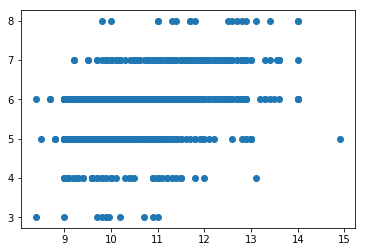

In [25]:
plt.scatter(df['alcohol'],df['quality'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1217bcbe0>,
      dtype=object)

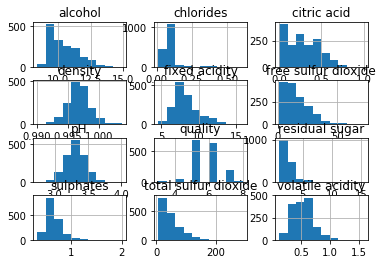

In [38]:
df.hist(bins=10)

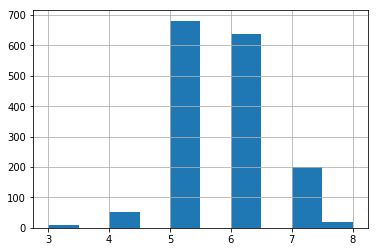

In [39]:
df['quality'].hist(bins=10)

### Step 4 - Form some impressions of the data
* Dataset looks clean
* Quality output variable, I think because of measurement system, lacks any extreme scores; remember, the README says that (3) wine experts rated the sample and the median quality score was recorded.
* I see several right-tailed distributions on input variables, my impression is that those variables are ideally zero or very low, I wonder how impactful of features they'll be, in moderation.
* The README mentioned they used SVM with good success, but I don't think I should follow an already known approach and my first thought was to try KNN or Logistical Regression
* For KNN, I think we should normalize features to give equal weight

In [324]:
#The amount of quality scores of 5 and 6 seems to dominate the dataset, concerns here:
print(df['quality'][df.quality == 5].count())
print(df['quality'][df.quality == 6].count())
print(df['quality'].count())

681
638
1599


### Step 5 - Data split

In [243]:
#Remove output variable from input dataset
data_x = df.drop(columns='quality')

#Z-Normalize the input variables
data_x_norm = data_x.apply(zscore)

#Create a separate dataframe for output variable
data_y = df['quality']

TEST_SPLIT = 0.15

#Shuffling is on by default, I didn't notice an order in the data set,
#but I think shuffling is probably a good practice:
train_x, test_x, train_y, test_y = train_test_split(data_x_norm, data_y , test_size=TEST_SPLIT)

In [258]:
#Check
print(df.head())
print(data_x.head())
print("Z-Norm")
print(data_x_norm.head())
print("Output")
print(data_y.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [259]:
#Check splits
train_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
846,-1.102890,0.626688,-0.313113,-0.524166,-0.137438,-0.179300,-0.470360,0.075962,1.806985,0.010924,-0.584777
552,0.678154,-0.378878,-0.159061,0.114364,0.096353,-0.179300,-0.075043,0.664277,-1.238276,0.483029,-0.397043
319,0.735607,1.352930,-0.775267,0.256260,-0.116184,1.350792,0.837226,1.008786,-0.072005,-0.107102,-0.021574
392,0.678154,-0.881661,1.278752,-0.382271,-0.116184,-0.944346,-0.622404,0.664277,-0.849519,-0.874272,-0.866379
1423,-1.102890,0.012176,-0.929318,0.965737,0.755218,-0.179300,-0.470360,0.028261,1.223850,0.069937,0.541630


In [260]:
test_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
263,-0.241094,-0.881661,-0.210412,-0.524166,-0.222453,0.681377,0.077002,-0.236746,-0.201591,0.069937,-1.054113
730,0.678154,0.123905,1.997658,-0.169427,6.366201,-0.370562,-0.287906,0.770280,-0.914312,0.069937,-0.772512
1275,-0.183641,1.045674,-0.261762,-0.169427,-0.264960,-0.274931,1.050089,0.070662,-0.460762,-0.697233,-0.866379
27,-0.241094,-0.546472,-0.313113,-0.666062,0.393905,-0.561823,-0.287906,-0.077742,-0.914312,1.486251,-0.866379
1251,-0.470907,0.291499,-0.672566,-0.240375,-0.222453,1.063900,0.411500,-0.236746,-0.201591,-0.402167,-0.584777


In [261]:
train_y.head()

846     5
552     6
319     6
392     5
1423    4
Name: quality, dtype: int64

In [262]:
test_y.head()

263     5
730     5
1275    6
27      5
1251    5
Name: quality, dtype: int64

### Step 6 - KNN Classifier


Best accuracy:0.6333333333333333 Neighbors:1


Text(0, 0.5, 'Accuracy')

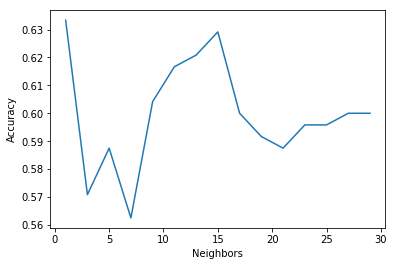

In [255]:
#Let's interate and find best accuracy
best_accr = 0
best_neighbor = 0

n = np.arange(1,30,2)
acc = np.zeros(len(n))
for i,j in enumerate(n):
    knn = KNeighborsClassifier(n_neighbors=j)
    knn.fit(train_x, train_y)
    accuracy = knn.score(test_x, test_y)
    acc[i] = accuracy
    if accuracy > best_accr:
        best_accr = accuracy
        best_neighbor = j
print("Best accuracy:{} Neighbors:{}".format(best_accr,best_neighbor))
plt.plot(n,acc)
plt.xlabel("Neighbors")
plt.ylabel("Accuracy")

### KNN - Results
* Before normalization, I was getting poor results from KNN classifier, 48-53% accuracy, depending on neighbors
* Best accuracy after z-norm is 67%, with 1 neighbor, but I don't know how meaningful this is
* Tried adjusting test/train split, and also Manhattan distance in KNN, no significant change
* Could it be, we need to remove unimportant features?  But how?

### Step 7 - SVM Classifier
*  Try SVM to see if better accuracy than KNN

In [265]:
from sklearn.svm import SVC
classifier = SVC(gamma='auto') #Tried auto and scale, but didn't think I should use scale, since already z-norm
classifier.fit(train_x, train_y)
#Predicting the Test Set
classifier.score(test_x,test_y)

0.6416666666666667

### SVM Results
*  Very similar to KNN, I still think features may be an issue
*  Was also wondering about output variable, remember strong dataset with output of 5,6 could we somehow generalize wine quality and simplify prediction?  Like quality of 1,2,3?  Poor, Good, Great?  Asked another way... isn't a wine quality score of 1 to 10 a little too precise for a taster?

### Step 8 - Final Adjustments to Get Better Accuracy

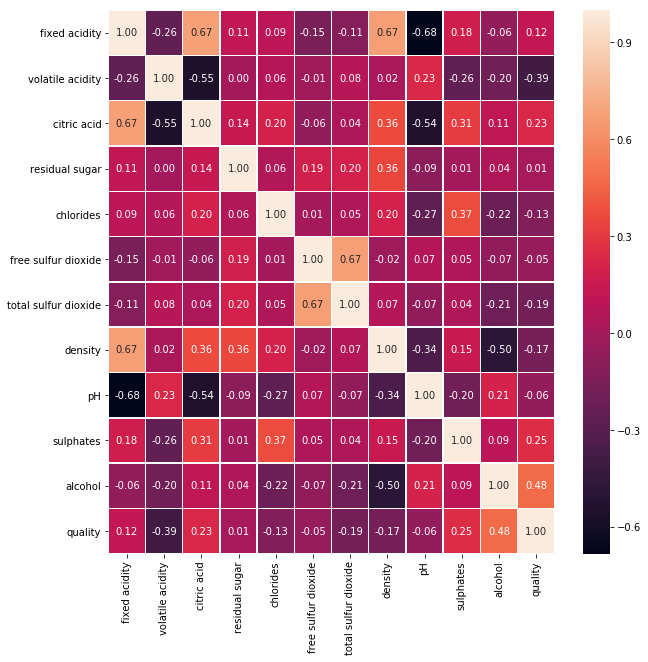

In [276]:
#Seaborn has a nice correlation matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

In [280]:
#Could we try and remove the seemingly, low-impact input variables and retry our classifier?
df_reduced = df.drop(columns=['residual sugar','free sulfur dioxide','pH','fixed acidity'])

In [285]:
#Let's retry
data_x = df_reduced.drop(columns='quality')
data_x_norm = data_x.apply(zscore)
data_y = df_reduced['quality']
TEST_SPLIT = 0.2

train_x, test_x, train_y, test_y = train_test_split(data_x_norm, data_y , test_size=TEST_SPLIT)
classifier = SVC(gamma='auto')
classifier.fit(train_x, train_y)
classifier.score(test_x,test_y)

0.634375

#### Reducing features didn't have meaningful impact, perhaps we try reshaping the output classes?

In [312]:
#Binning with Pandas
quality_binned = pd.cut(df['quality'], (1,4,6,10), labels=["poor", "ok", "good"])

In [313]:
#We created some simple wine quality classes
quality_binned.value_counts()

ok      1319
good     217
poor      63
Name: quality, dtype: int64

In [ ]:
df.head(20)

In [ ]:
quality_binned

In [319]:
#Encode the quality classes
LE = LabelEncoder()
LE.fit(quality_binned)
norm_labels = LE.transform(quality_binned)

In [320]:
norm_labels

array([1, 1, 1, ..., 1, 1, 1])

In [323]:
#Retrain
data_x = df.drop(columns='quality')
data_x_norm = data_x.apply(zscore)
data_y = norm_labels
TEST_SPLIT = 0.2

train_x, test_x, train_y, test_y = train_test_split(data_x_norm, data_y , test_size=TEST_SPLIT)
classifier = SVC(gamma='auto')
classifier.fit(train_x, train_y)
classifier.score(test_x,test_y)

0.865625

### Conclusion
*  Whether it is frowned upon in data science community or not, or perhaps by your ultimate customer you're performance the analytical services for, I think simplifying the output variable to larger classes helps the classifer and provides more meaningful insight
*  KNN and SVM had similar performance for this dataset
*  Was surprised reducing some features had limited effect
*  Curious to learn more about pros/cons of altering the output classes